# Project Overview  

This project implements a **Denoising Diffusion Probabilistic Model (DDPM)** using PyTorch to learn the distribution of sprite images and generate new samples. The generated images are evaluated using the **Fréchet Inception Distance (FID) score** to measure their quality and similarity to real images.  

## Key Features  
- Implementation of **DDPM** for image generation.  
- Training on the **Sprites dataset** with a diffusion-based approach.  
- Comparison with **DDIM (Denoising Diffusion Implicit Model)** for faster sampling.  
- Evaluation using **FID Score** to assess generation quality.  

This project is optimized to run on **Google Colab** to take advantage of GPU acceleration. The implementation is flexible, allowing modifications to function inputs and additional enhancements as needed.

# Setup

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

## hyperparameters


In [ ]:
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/content/'

batch_size = 100
n_epoch = 40
lrate=1e-3

## Sprites Dataset

In [ ]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

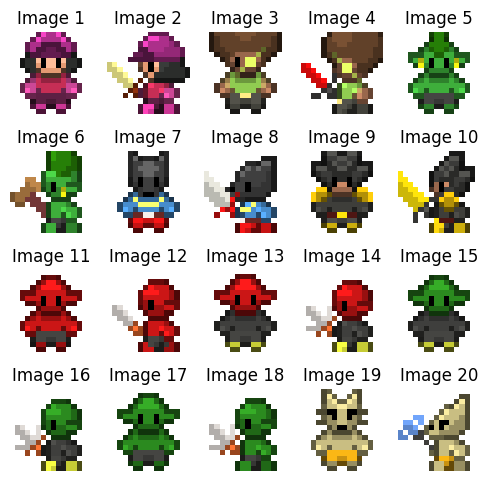

In [ ]:
sprites_samples = np.load("/content/sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

for i in range(20):
    image = sprites_samples[i]

    axes[i].imshow(image)
    axes[i].axis('off')  
    axes[i].set_title(f'Image {i + 1}') 

for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    def __len__(self):
        return len(self.sprites)

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                
    transforms.Normalize((0.5,), (0.5,)) 
])

In [6]:
sprites = np.load("/content/sprites_1788_16x16.npy")
slabels = np.load("/content/sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [ ]:
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

## Model Architecture: UNet for Denoising  

To remove noise from images, we use **UNet**, a powerful architecture designed for **image segmentation**. Unlike traditional autoencoders, UNet preserves fine details using **skip connections**, making it ideal for **denoising**.  

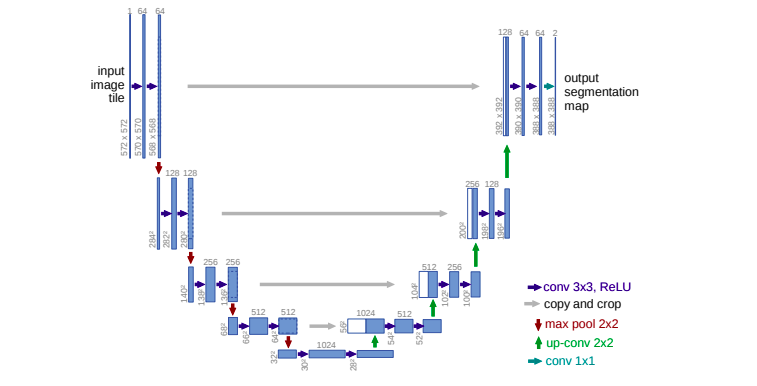

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network.

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        self.same_channels = in_channels == out_channels

        self.is_res = is_res

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   
            nn.BatchNorm2d(out_channels),   
            nn.GELU(),   
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   
            nn.BatchNorm2d(out_channels),  
            nn.GELU(),   
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2

            return out / 1.414

        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    def get_out_channels(self):
        return self.conv2[0].out_channels

    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  
        super(Unet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height 

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)       
        self.down2 = UnetDown(n_feat, 2 * n_feat)    
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), 
            nn.GroupNorm(8, 2 * n_feat), 
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), 
            nn.GroupNorm(8, n_feat), 
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        hiddenvec = self.to_vec(down2)

        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [ ]:
nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [ ]:
betas = torch.linspace(beta1, beta2, timesteps).to(device)

### Forward

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths ([link](https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick)) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [16]:
alpha = 1. - betas
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

def perturb_input(x0, t):
    noise = torch.randn_like(x0).to(device)

    sqrt_alpha_bar = alpha_bar[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)

    noised_images = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise

    return noised_images, noise

### Train Diffusion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

In [17]:
def train_diffusion(model, optimizer, train_loader, val_loader, timesteps, num_epochs, device):
    beta = torch.linspace(0.0001, 0.02, timesteps).to(device)
    alpha = 1. - beta
    alpha_bar = torch.cumprod(alpha, dim=0).to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, _ in train_loader:
            images = images.to(device)

            t = torch.randint(0, timesteps, (images.size(0),), device=device).long()

            noise = torch.randn_like(images).to(device)

            sqrt_alpha_bar_t = alpha_bar[t].sqrt().view(-1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)
            x_t = sqrt_alpha_bar_t * images + sqrt_one_minus_alpha_bar_t * noise

            predicted_noise = model(x_t, t / timesteps)

            loss = F.mse_loss(predicted_noise, noise)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)

                t = torch.randint(0, timesteps, (images.size(0),), device=device).long()

                noise = torch.randn_like(images).to(device)

                sqrt_alpha_bar_t = alpha_bar[t].sqrt().view(-1, 1, 1, 1)
                sqrt_one_minus_alpha_bar_t = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)
                x_t = sqrt_alpha_bar_t * images + sqrt_one_minus_alpha_bar_t * noise

                predicted_noise = model(x_t, t / timesteps)

                loss = F.mse_loss(predicted_noise, noise)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch: {epoch + 1}")
        print(f"Train loss: {train_loss:.8f}")
        print(f"Val loss: {val_loss:.8f}")

    return train_losses, val_losses

In [18]:
train_losses, val_losses = train_diffusion(
    model=nn_model,
    optimizer=optim,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    timesteps=timesteps,
    num_epochs=n_epoch,
    device=device
)

Epoch: 1
Train loss: 0.07312372
Val loss: 0.07579365
Epoch: 2
Train loss: 0.07029939
Val loss: 0.07119459
Epoch: 3
Train loss: 0.06701914
Val loss: 0.06730935
Epoch: 4
Train loss: 0.06421305
Val loss: 0.06728042
Epoch: 5
Train loss: 0.06294645
Val loss: 0.06337011
Epoch: 6
Train loss: 0.06094674
Val loss: 0.06261588
Epoch: 7
Train loss: 0.05882576
Val loss: 0.05920525
Epoch: 8
Train loss: 0.05781702
Val loss: 0.05805864
Epoch: 9
Train loss: 0.05567482
Val loss: 0.05913802
Epoch: 10
Train loss: 0.05416817
Val loss: 0.05463469
Epoch: 11
Train loss: 0.05272227
Val loss: 0.05696440
Epoch: 12
Train loss: 0.05217540
Val loss: 0.05149782
Epoch: 13
Train loss: 0.05144849
Val loss: 0.05197286
Epoch: 14
Train loss: 0.05067696
Val loss: 0.05115724
Epoch: 15
Train loss: 0.04927098
Val loss: 0.05014671
Epoch: 16
Train loss: 0.04918251
Val loss: 0.05021881
Epoch: 17
Train loss: 0.04808111
Val loss: 0.04793035
Epoch: 18
Train loss: 0.04797922
Val loss: 0.04948941
Epoch: 19
Train loss: 0.04610187
Val 

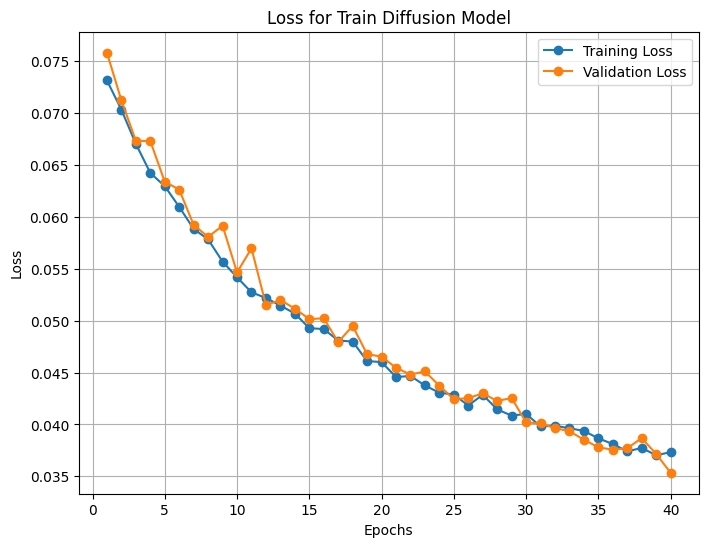

In [19]:
epochs = list(range(1, len(val_losses) + 1))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for Train Diffusion Model')
plt.legend()
plt.grid()
plt.show()

## Reverse process: DDPM Sampling

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \
Below image show the sampling algorithm

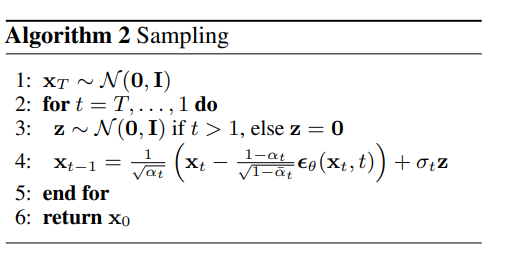

In [ ]:
def p_xt_ddpm(current_noise_image, predicted_noise, time_step, alpha, alpha_bar, beta):
    sqrt_alpha = alpha[time_step].sqrt()
    sqrt_one_minus_alpha_bar = (1 - alpha_bar[time_step]).sqrt()
    noise_coefficient = beta[time_step].sqrt() if time_step > 0 else 0

    mean = (1 / sqrt_alpha) * (current_noise_image - (1 - alpha[time_step]) / sqrt_one_minus_alpha_bar * predicted_noise)

    z = torch.randn_like(current_noise_image) if time_step > 0 else 0
    return mean + noise_coefficient * z

def sample_ddpm(model, num_samples, timesteps, device, alpha, alpha_bar, beta):
    samples = torch.randn(num_samples, 3, 16, 16).to(device)
    intermediate_images = []

    model.eval()
    with torch.no_grad():
        for t in range(timesteps - 1, -1, -1):
            t_tensor = torch.full((num_samples,), t, device=device).float() / timesteps
            predicted_noise = model(samples, t_tensor)
            samples = p_xt_ddpm(samples, predicted_noise, t, alpha, alpha_bar, beta)

            if t % (timesteps // 5) == 0 or t < 8:
                intermediate_images.append(samples.clone().cpu())

    return samples, intermediate_images

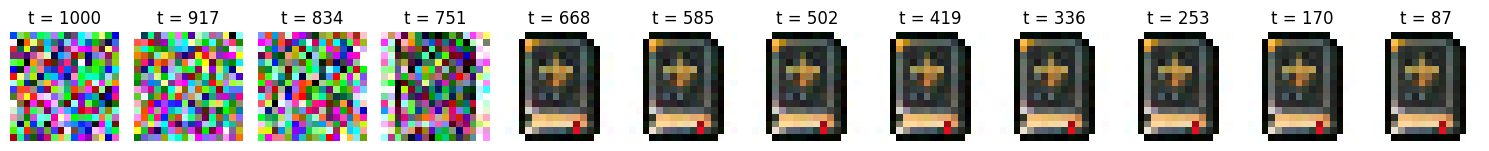

In [25]:
beta = torch.linspace(0.0001, 0.02, timesteps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

num_samples = 1
samples, intermediate_images = sample_ddpm(nn_model, num_samples, timesteps, device, alpha, alpha_bar, beta)

fig, axes = plt.subplots(1, len(intermediate_images), figsize=(15, 5))
for i, img in enumerate(intermediate_images):
    grid = make_grid(img, nrow=num_samples, normalize=True, value_range=(-1, 1))
    axes[i].imshow(grid.permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f"t = {timesteps - i * (timesteps // len(intermediate_images))}")
plt.tight_layout()
plt.show()

## Reverse process: DDIM Sampling

In [26]:
def p_xt_ddim(current_noise_image, predicted_noise, time_step, alpha, alpha_bar, eta=0.0):
    if time_step == 0:
        return current_noise_image 

    sqrt_alpha_bar_t = alpha_bar[time_step].sqrt()
    sqrt_one_minus_alpha_bar_t = (1 - alpha_bar[time_step]).sqrt()
    x0 = (current_noise_image - sqrt_one_minus_alpha_bar_t * predicted_noise) / sqrt_alpha_bar_t

    sqrt_alpha_bar_t_prev = alpha_bar[time_step - 1].sqrt()
    sqrt_one_minus_alpha_bar_t_prev = (1 - alpha_bar[time_step - 1]).sqrt()
    sigma_t = eta * ((1 - alpha_bar[time_step - 1]) / (1 - alpha_bar[time_step]) * (1 - alpha[time_step])).sqrt()

    z = torch.randn_like(current_noise_image) if eta > 0 else 0 
    x_t_minus_1 = sqrt_alpha_bar_t_prev * x0 + sqrt_one_minus_alpha_bar_t_prev * predicted_noise + sigma_t * z

    return x_t_minus_1

def sample_ddim(model, num_samples, timesteps, device, alpha, alpha_bar, eta=0.0):
    samples = torch.randn(num_samples, 3, 16, 16).to(device)
    intermediate_images = []

    model.eval()
    with torch.no_grad():
        for t in range(timesteps - 1, -1, -1):
            t_tensor = torch.full((num_samples,), t, device=device).float() / timesteps
            predicted_noise = model(samples, t_tensor)
            samples = p_xt_ddim(samples, predicted_noise, t, alpha, alpha_bar, eta)

            if t % (timesteps // 5) == 0 or t < 8:
                intermediate_images.append(samples.clone().cpu())

    return samples, intermediate_images

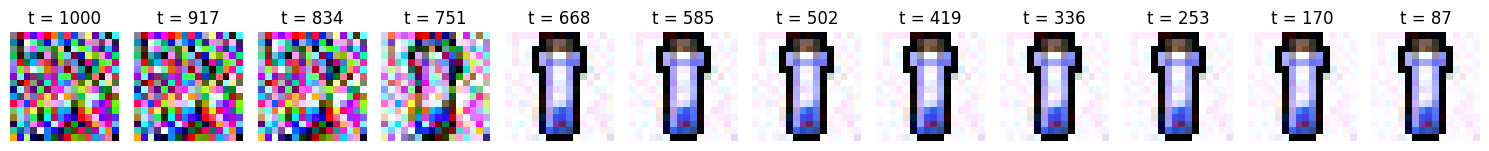

In [28]:
beta = torch.linspace(0.0001, 0.02, timesteps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

num_samples = 1
samples, intermediate_images = sample_ddim(nn_model, num_samples, timesteps, device, alpha, alpha_bar, eta=0.0)

fig, axes = plt.subplots(1, len(intermediate_images), figsize=(15, 5))
for i, img in enumerate(intermediate_images):
    grid = make_grid(img, nrow=num_samples, normalize=True, value_range=(-1, 1))
    axes[i].imshow(grid.permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f"t = {timesteps - i * (timesteps // len(intermediate_images))}")
plt.tight_layout()
plt.show()

## Results

Plot 20 generated images by each of generation processes implemented in the previous part

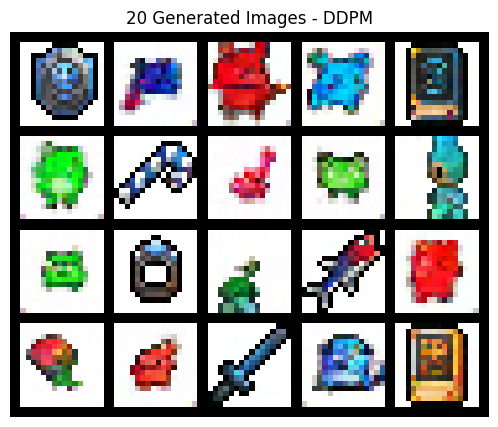

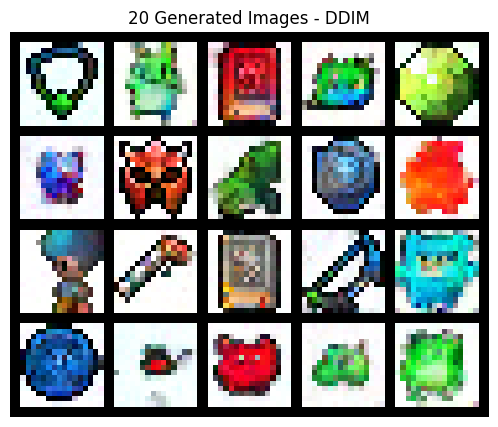

In [30]:
beta = torch.linspace(0.0001, 0.02, timesteps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

num_samples = 20

ddpm_generated_images, _ = sample_ddpm(nn_model, num_samples, timesteps, device, alpha, alpha_bar, beta)

ddim_generated_images, _ = sample_ddim(nn_model, num_samples, timesteps, device, alpha, alpha_bar, eta=0.0)

plt.figure(figsize=(10, 5))
grid_ddpm = make_grid(ddpm_generated_images, nrow=5, normalize=True, value_range=(-1, 1))
plt.imshow(grid_ddpm.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title("20 Generated Images - DDPM")
plt.show()

plt.figure(figsize=(10, 5))
grid_ddim = make_grid(ddim_generated_images, nrow=5, normalize=True, value_range=(-1, 1))
plt.imshow(grid_ddim.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title("20 Generated Images - DDIM")
plt.show()


# Evaluating the Generated Samples:

Now we want to evaluate our model. For this, we use the [FID score](https://github.com/mseitzer/pytorch-fid).

In [31]:
!pip install -qq pytorch-fid

In [32]:
import os
from torchvision.utils import save_image

generated_dir = "./generated_images"
real_dir = "./real_images"

os.makedirs(generated_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)

num_samples = 3000
generated_images, _ = sample_ddpm(nn_model, num_samples, timesteps, device, alpha, alpha_bar, beta)

for i in range(len(generated_images)):
    save_image(generated_images[i], os.path.join(generated_dir, f"generated_{i}.png"), normalize=True, value_range=(-1, 1))

for i in range(3000):
    real_image = train_sprites[i]
    real_image_tensor = transform(real_image)
    save_image(real_image_tensor, os.path.join(real_dir, f"real_{i}.png"), normalize=True, value_range=(-1, 1))

print("Images saved successfully.")

Images saved successfully.


In [33]:
!python -m pytorch_fid ./real_images ./generated_images

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 276MB/s]
100% 60/60 [00:12<00:00,  4.98it/s]
100% 60/60 [00:11<00:00,  5.06it/s]
FID:  31.996654421590506
